In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [7]:
from nbodykit.lab import *
from nbodykit import style

import numpy as np
import matplotlib.pyplot as plt
plt.style.use(style.notebook)

### Painting the Overdensity field
Default field that is painted: $1+\delta(x)$.

Note that by def of $\delta$:
- $min(\delta) = -1$
- $\langle \delta \rangle = 0$

In [3]:
# initialize unbiased log-normal catalog
redshift = 0.55
cosmo = cosmology.Planck15
Plin = cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu')

cat = LogNormalCatalog(Plin=Plin, nbar=3e-3, BoxSize=1380, Nmesh=256, bias=1.0, seed=42)
mesh = cat.to_mesh(resampler='tsc', compensated=False, interlaced=False) # Nmesh inherited from cat

In [4]:
# get painted density field on the mesh as a real field adn print basic stats
one_plus_delta = mesh.paint(mode='real')
print("mean of 1+delta = ", one_plus_delta.value.mean())
print("min of 1+delta = ", one_plus_delta.value.min())
print("max of 1+delta = ", one_plus_delta.value.max())

mean of 1+delta =  1.0000004
min of 1+delta =  0.0
max of 1+delta =  18.71194


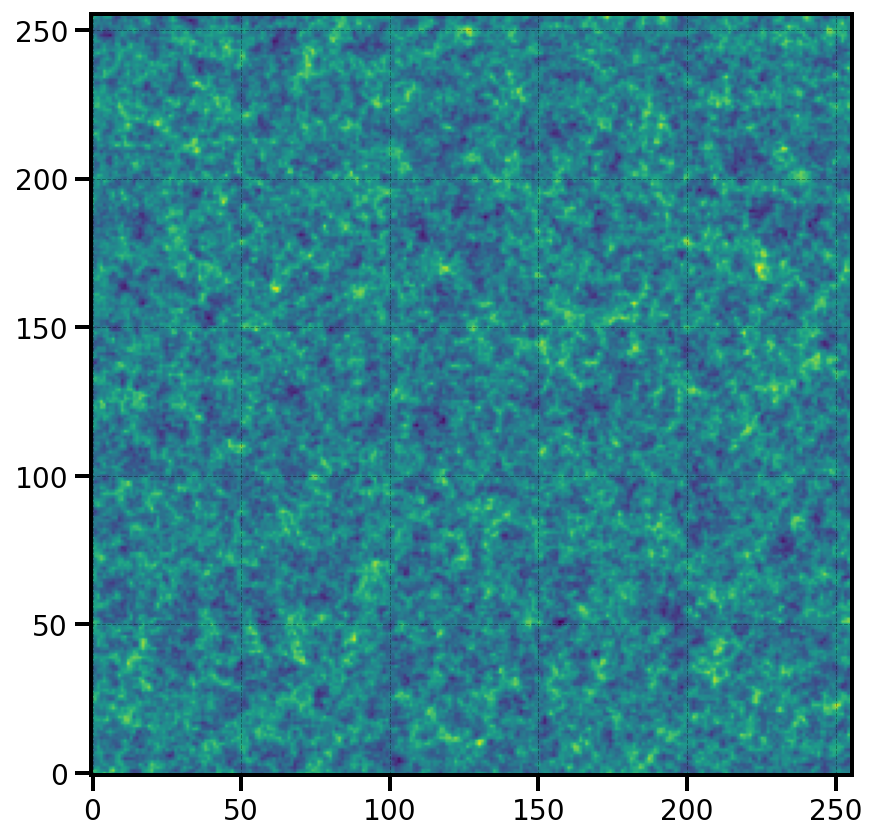

In [6]:
# quick preview
plt.imshow(one_plus_delta.preview(axes=[0,1]), origin='lower')

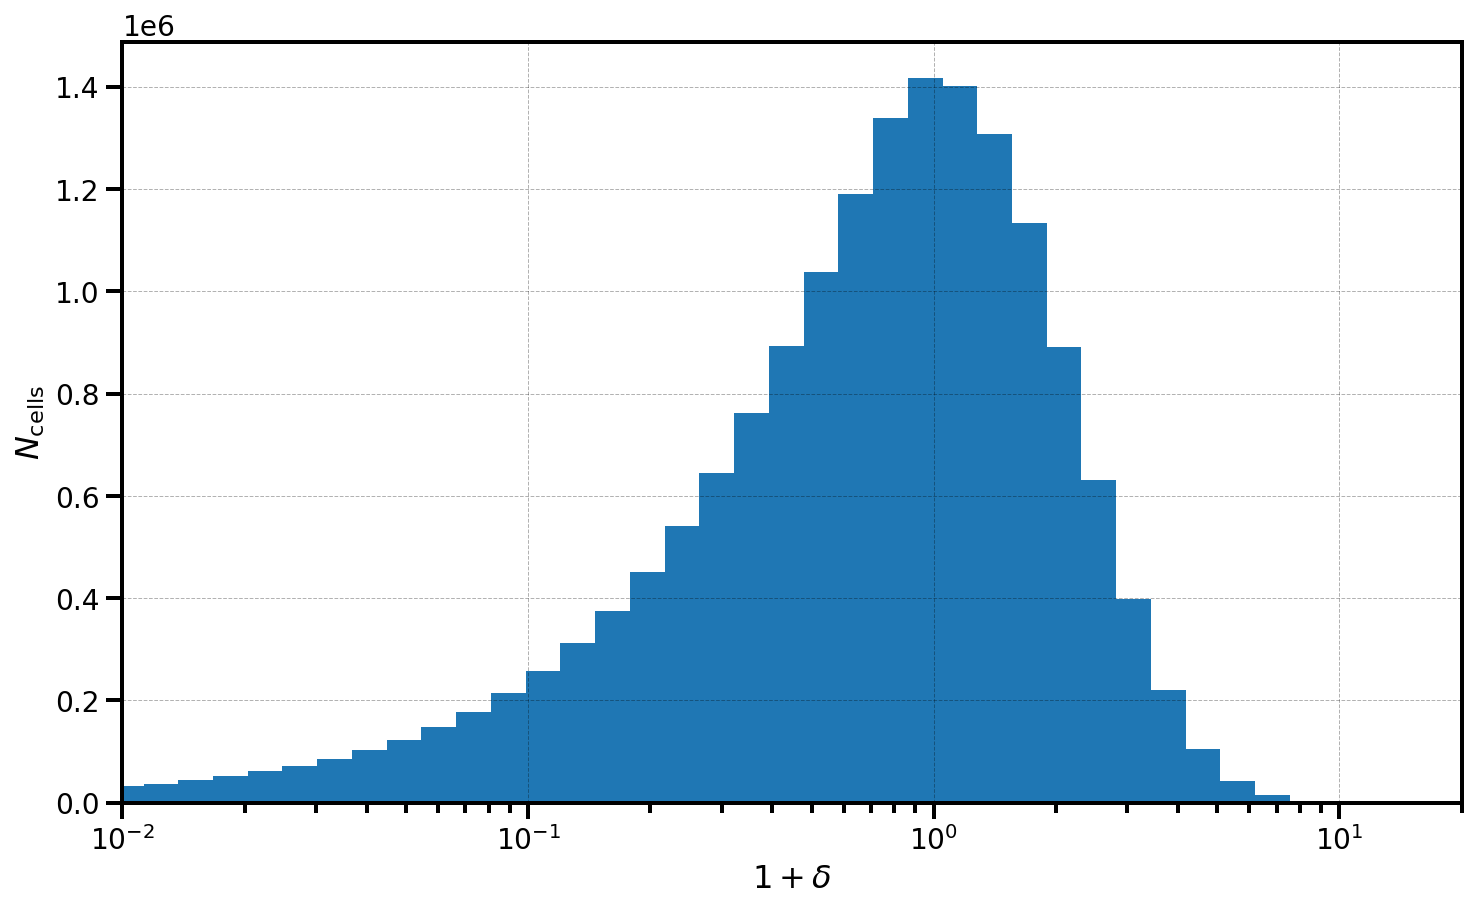

In [11]:
# Make Histogram for how many cells contain a certainvalue of 1+delta.
# Expect approx log-normal dist
# Need to flatten painted density field as its 3D
bins = np.logspace(-7, np.log10(30), 100)
plt.hist(one_plus_delta.value.flatten(), bins=bins)

plt.xscale('log')
plt.xlabel(r"$1+\delta$")
plt.ylabel(r"$N_\mathrm{cells}$")
plt.xlim(1e-2, 20)
plt.show()

### Painting LOS momentum field
Generally, painted field value is: $F(x) = (1+\delta(x))V(x)$ with $V(x)$ being the catalog column `value`; unity by default. Change to LOS velocity to get the LOS velocity weighted mass field i.e. the LOS momentum field. 

Take x axis as LOS. Need x component of vel field in units of $Mpc/h$ which is stored in `VelocityOffset` for all directions.

In [12]:
LOS = [1,0,0]
cat['Vx'] = cat['VelocityOffset'][:,0]

mom_mesh = cat.to_mesh(resampler='tsc', compensated=True, value='Vx')

In [13]:
# auto power spectrum of overdensity field
r00 = FFTPower(mesh, mode='1d', los=LOS)

# cross power spectrum of mass and momentum field
r01 = FFTPower(mom_mesh, second=mesh, mode='1d', poles=[1], los=LOS)

# auto power spectrum of momentum field
r11 = FFTPower(mom_mesh, mode='1d', poles=[2], los=LOS)

Now we can use these spectra to approximate $P(k,\mu)$ (according to Vlah 2012) and compare it the linear theory result by Kaiser:

- Vlah: $P(k, \mu) =  P_{00}(k) - 2ik\mu P_{01}(k,\mu) + k^2\mu^2P_{11}(k,\mu)$
- Kaiser: $P_{lin}(k,\mu) = P_{lin}(k) + 2f\mu^2P_{lin}(k) + f^2\mu^2P_{lin}(k)$

In [28]:
P00 = r00.power['power'].real - r00.attrs['shotnoise'] # auto density
P01 = 2 * r01.poles['k'] * r01.poles['power_1'].imag # cross density mom 
P11 = 1.5 * r11.poles['k']**2 * r11.poles['power_2'].real # auto mom

def Vlah(mu):
    return P00 -2j*r01.power['k']*P01 + r11.power['k']**2*mu**2*P11 

In [27]:
k = np.logspace(-2, 0, 500)
f = cosmo.scale_independent_growth_rate(redshift)

def Kaiser(mu):
    return Plin(k)*(1 + f*mu**2*(2 + f))

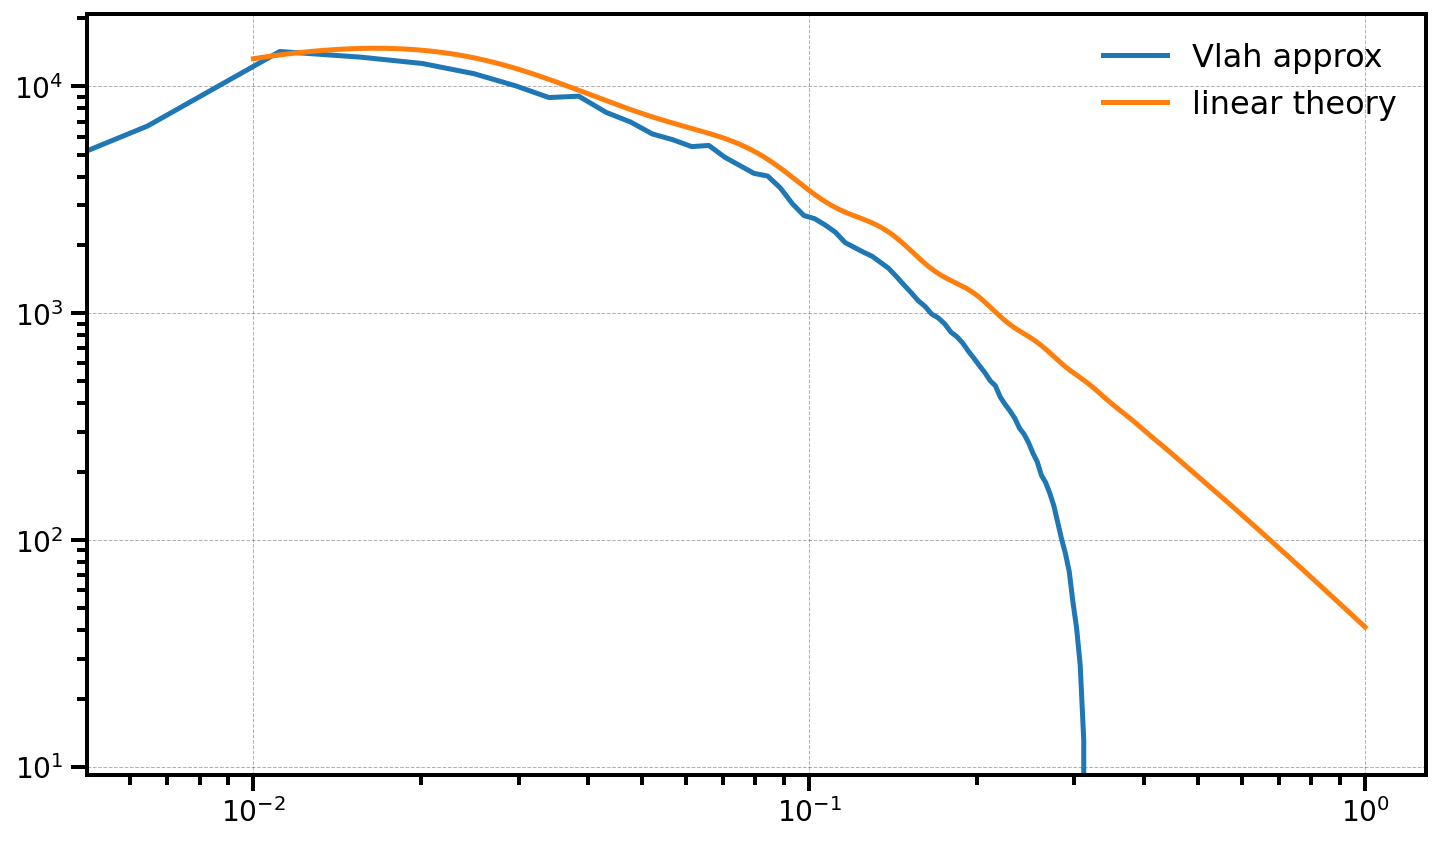

In [31]:
mu = 0.2

plt.loglog(r00.power['k'], Vlah(mu), label='Vlah approx')
plt.loglog(k, Kaiser(mu), label='linear theory')
plt.legend(frameon=False)
plt.show()

See Cookbook doc for different kind of plotting